Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then run the cells accordingly.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [14]:
NAME = "江詠筑"
COLLABORATORS = "張又仁 陳志誠"

---

# Mask R-CNN for Bin Picking

This notebook is adopted from the [TorchVision 0.3 Object Detection finetuning tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).  We will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model on a dataset generated from our "clutter generator" script.


In [15]:
# Imports
import fnmatch
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data

ycb = [
    "003_cracker_box.sdf", "004_sugar_box.sdf", "005_tomato_soup_can.sdf",
    "006_mustard_bottle.sdf", "009_gelatin_box.sdf", "010_potted_meat_can.sdf"
]

#drake_reserved_labels = [32765, 32764, 32766, 32767]

def colorize_labels(image):
    """Colorizes labels."""
    cc = mpl.colors.ColorConverter()
    color_cycle = plt.rcParams["axes.prop_cycle"]
    colors = np.array([cc.to_rgb(c["color"]) for c in color_cycle])
    bg_color = [0, 0, 0]
    image = np.squeeze(image)
    background = np.zeros(image.shape[:2], dtype=bool)
    for label in reserved_labels:
        background |= image == int(label)
    foreground = image[np.logical_not(background)]
    color_image = colors[image % len(colors)]
    color_image[background] = bg_color
    return color_image


# Download our bin-picking model

And a small set of images for testing.

In [16]:
dataset_path = 'clutter_maskrcnn_data'
if not os.path.exists(dataset_path):
    !wget https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_test.zip .
    !unzip -q clutter_maskrcnn_test.zip

num_images = len(fnmatch.filter(os.listdir(dataset_path),'*.png'))
def open_image(idx):
    filename = os.path.join(dataset_path, f"{idx:05d}.png")
    return Image.open(filename).convert("RGB")

model_file = 'clutter_maskrcnn_model.pt'
if not os.path.exists(model_file):
    !wget https://groups.csail.mit.edu/locomotion/clutter_maskrcnn_model.pt .

# Load the model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms.functional as Tf


## Part A (3 points)
* load an instance segmentation model pre-trained on COCO
* get the number of input features for the classifier
* replace the pre-trained head with a new one
* now get the number of input features for the mask classifier
* and replace the mask predictor with a new one

In [17]:
def get_instance_segmentation_model(num_classes):
    #load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    #get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

    #now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    #and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)

    return model

num_classses = len(ycb)+1
model = get_instance_segmentation_model(num_classes)
model.load_state_dict(torch.load('clutter_maskrcnn_model.pt'))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [18]:
num_classes = len(ycb)+1
model = get_instance_segmentation_model(num_classes)
model.load_state_dict(torch.load('clutter_maskrcnn_model.pt'))
model.eval()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Evaluate the network

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's assert the predicted labels are expected
```
ycb = [
    "003_cracker_box.sdf", 
    "004_sugar_box.sdf", 
    "005_tomato_soup_can.sdf",
    "006_mustard_bottle.sdf", 
    "009_gelatin_box.sdf", 
    "010_potted_meat_can.sdf"
]
```
The index 3 and 4 represent "006_mustard_bottle.sdf" and "009_gelatin_box.sdf", respectively.

In [19]:
# pick one image from the test set (choose between 9950 and 9999)
img = open_image(9952)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

print(prediction)

assert prediction[0]['labels'].cpu().data.numpy()[0] == 3
assert prediction[0]['labels'].cpu().data.numpy()[1] == 4
assert prediction[0]['labels'].cpu().data.numpy()[2] == 4

[{'boxes': tensor([[359.1218, 122.6053, 427.2026, 277.1689],
        [441.9897, 149.1264, 520.0983, 232.2532],
        [394.6456, 288.7471, 482.7730, 365.8892],
        [404.5188, 152.9850, 481.1989, 296.8480],
        [415.9419, 158.8310, 489.6176, 271.0356]], device='cuda:0'), 'labels': tensor([3, 4, 4, 3, 4], device='cuda:0'), 'scores': tensor([1.0000, 0.9999, 0.9999, 0.9998, 0.0507], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

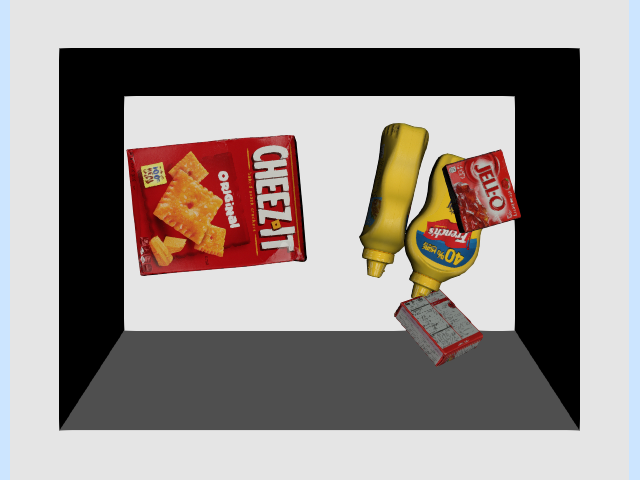

In [20]:
img

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

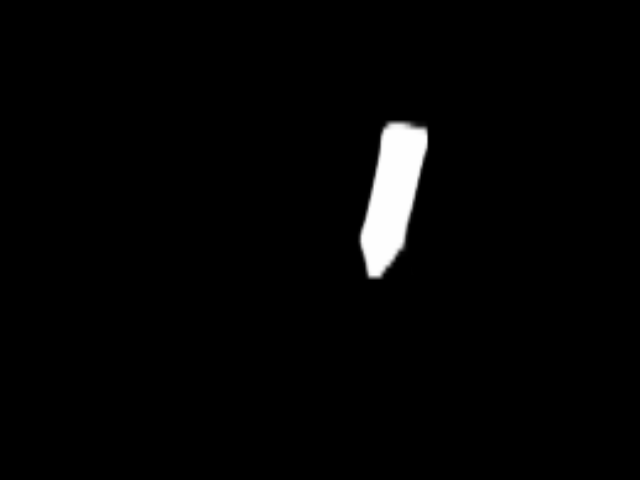

In [21]:
N = 0
Image.fromarray(prediction[0]['masks'][N, 0].mul(255).byte().cpu().numpy())

# Plot the object detections

<Figure size 432x288 with 0 Axes>

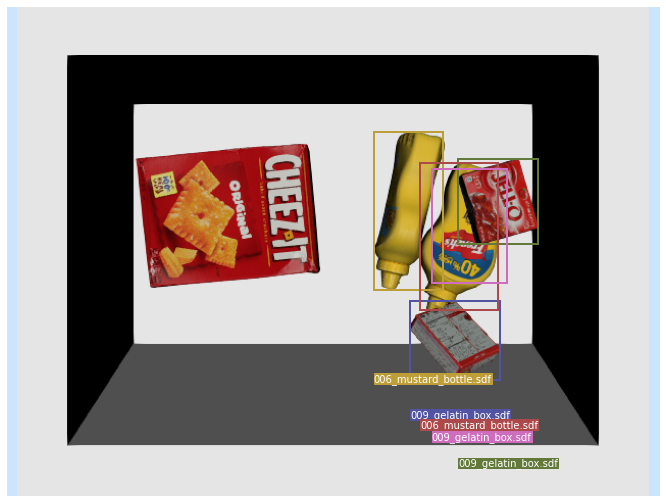

In [22]:
import matplotlib.patches as patches
import random

img_np = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img_np)

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

num_instances = prediction[0]['boxes'].shape[0]
bbox_colors = random.sample(colors, num_instances)
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()

for i in range(num_instances):
    color = bbox_colors[i]
    bb = boxes[i,:]
    bbox = patches.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1],
             linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    plt.text(bb[0], bb[0], s=ycb[labels[i]], 
            color='white', verticalalignment='top',
            bbox={'color': color, 'pad': 0})
plt.axis('off');

# Visualize the region proposals 

Let's visualize some of the intermediate results of the networks.

TODO: would be very cool to put a slider on this so that we could slide through ALL of the boxes.  But my matplotlib non-interactive backend makes it too tricky!

Region proposals (drawing first 20 out of 1000)


<Figure size 432x288 with 0 Axes>

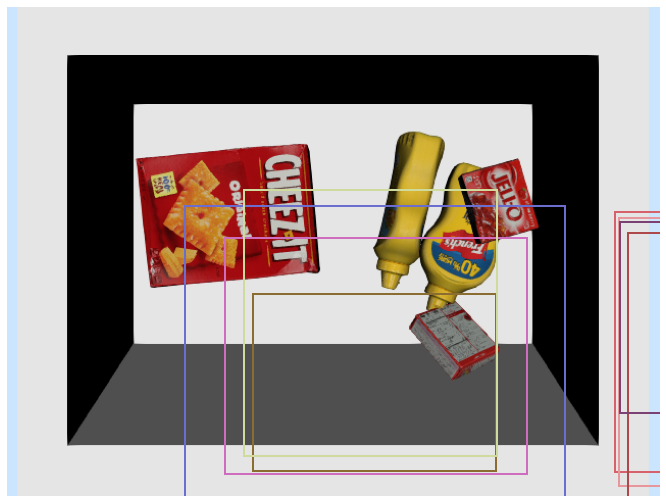

In [23]:
class Inspector:
    """A helper class from Kuni to be used for torch.nn.Module.register_forward_hook."""
    def __init__(self):
        self.x = None
    def hook(self, module, input, output):
        self.x = output

inspector = Inspector()
model.rpn.register_forward_hook(inspector.hook)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

rpn_values = inspector.x


img_np = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img_np)

cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

num_to_draw = 20
bbox_colors = random.sample(colors, num_to_draw)
boxes = rpn_values[0][0].cpu().numpy()
print(f"Region proposals (drawing first {num_to_draw} out of {boxes.shape[0]})")

for i in range(num_to_draw):
    color = bbox_colors[i]
    bb = boxes[i,:]
    bbox = patches.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1],
             linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
plt.axis('off');